In [ ]:
########################################################################################
########################################################################################

array([], shape=(0, 1024), dtype=float32)

In [62]:
from torchvision import transforms
from utils import *

data_dir = "Data"

# Create dataset DataFrame
df = create_dataset_df(data_dir)

print(df.info())

BATCH_SIZE = 32

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create data loader
val_loader = create_val_loader(
    df,
    val_transform=val_transform,
    batch_size=BATCH_SIZE,
    val_size=0.2
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86437 entries, 0 to 86436
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    86437 non-null  object
 1   label   86437 non-null  int64 
 2   class   86437 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB
None


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6457081].


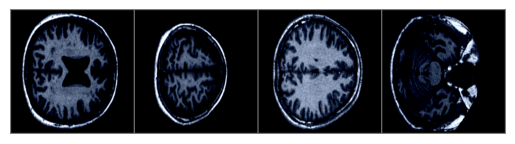

Labels: [2, 1, 0, 0]


In [63]:
# Function to unnormalize and display an image
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Assuming normalization with mean=0.5, std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some test images
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Display fewer images (e.g., 4 images)
num_images = 4
images = images[:num_images]  # Slice the batch
labels = labels[:num_images]

# Create a grid for the selected images
imshow(torchvision.utils.make_grid(images))
print("Labels:", labels.tolist())


c:\Users\georg\Documents\School\2024-Fall\CS4100\alzheimers-detection\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\georg\Documents\School\2024-Fall\CS4100\alzheimers-detection\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


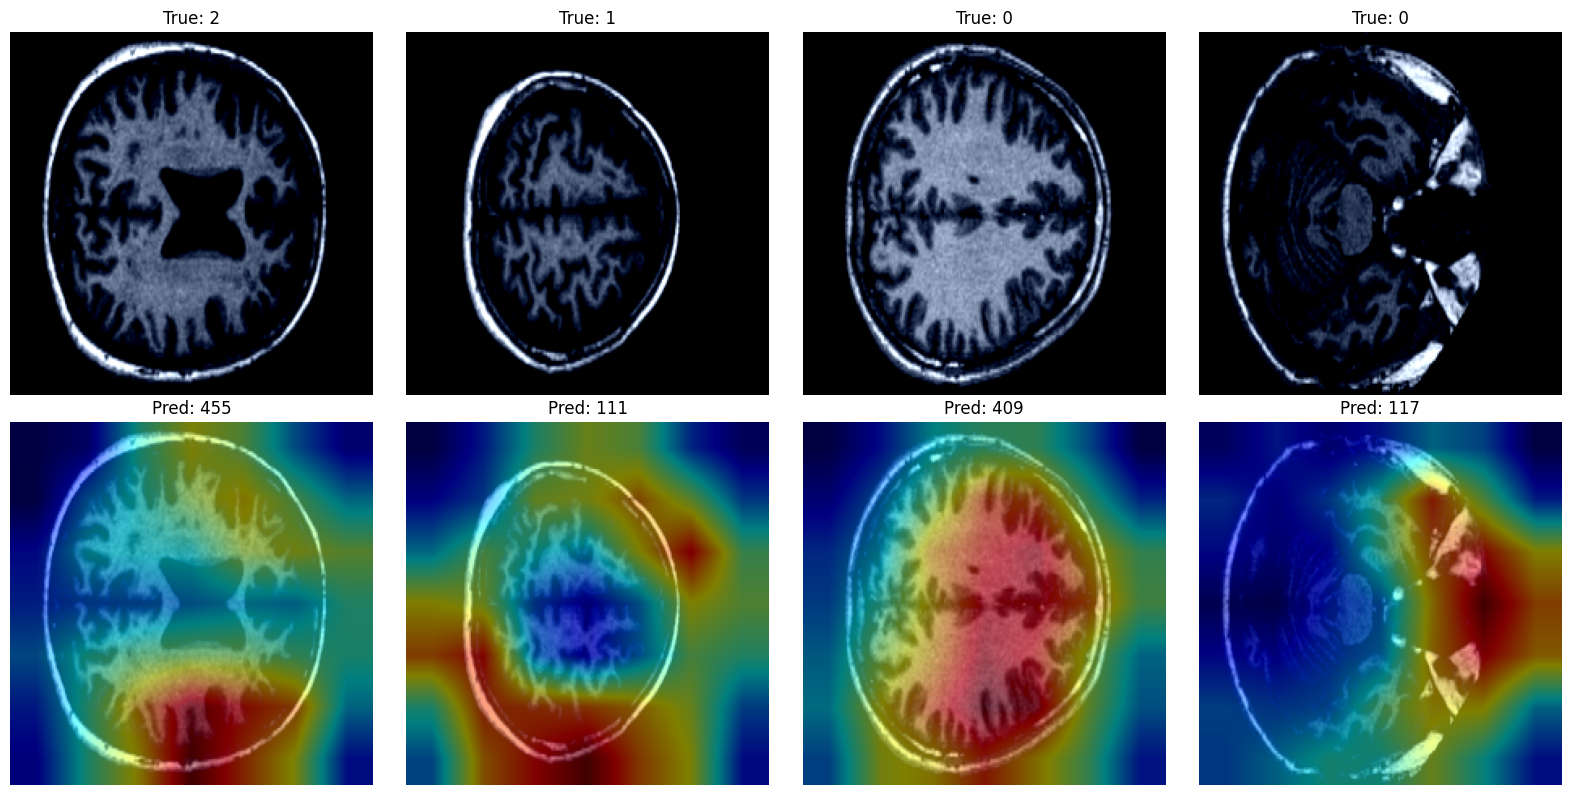

In [76]:
import torch
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def apply_gradcam(model, image_tensor, target_class=None):
    """
    Apply Grad-CAM visualization to a single image
    
    Args:
        model: PyTorch model (ResNet)
        image_tensor: Input image tensor [1, C, H, W]
        target_class: Optional target class index
    """
    # Define target layer for ResNet
    target_layers = [model.layer4[-1]]
    
    # Initialize GradCAM with reshape_transform for ResNet
    cam = GradCAM(
        model=model,
        target_layers=target_layers,
    )
    
    # Ensure input tensor is on the correct device
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)
    
    # If target class is not specified, use model's prediction
    if target_class is None:
        with torch.no_grad():
            outputs = model(image_tensor)
            target_class = outputs.argmax().item()
    
    targets = [ClassifierOutputTarget(target_class)]
    
    try:
        # Generate grayscale CAM
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        
        # Convert image tensor to numpy array for visualization
        image_np = image_tensor.cpu().squeeze().numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_np = image_np / 2 + 0.5  # Unnormalize
        image_np = np.clip(image_np, 0, 1)
        
        # Overlay CAM on image
        visualization = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
        
    except Exception as e:
        print(f"Error generating Grad-CAM: {str(e)}")
        # Return original image if Grad-CAM fails
        image_np = image_tensor.cpu().squeeze().numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_np = image_np / 2 + 0.5
        visualization = np.clip(image_np, 0, 1)
        
    return visualization, target_class

def visualize_batch_gradcam(model, images, labels, class_names=None):
    """
    Visualize Grad-CAM for a batch of images
    
    Args:
        model: PyTorch model
        images: Batch of images [B, C, H, W]
        labels: Ground truth labels
        class_names: Optional list of class names
    """
    model.eval()
    
    fig, axes = plt.subplots(2, len(images), figsize=(4*len(images), 8))
    
    for idx, (image, label) in enumerate(zip(images, labels)):
        # Original image
        image_np = image.cpu().numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_np = image_np / 2 + 0.5
        axes[0, idx].imshow(np.clip(image_np, 0, 1))
        axes[0, idx].axis('off')
        
        # Add title with true label
        title = f"True: {label}"
        if class_names:
            title = f"True: {class_names[label]}"
        axes[0, idx].set_title(title)
        
        # Generate and display Grad-CAM
        image_tensor = image.unsqueeze(0)
        cam_image, pred_class = apply_gradcam(model, image_tensor)
        axes[1, idx].imshow(cam_image)
        axes[1, idx].axis('off')
        
        # Add title with predicted class
        title = f"Pred: {pred_class}"
        if class_names:
            title = f"Pred: {class_names[pred_class]}"
        axes[1, idx].set_title(title)
    
    plt.tight_layout()
    plt.show()

# Example usage:

# Load your model
model = torchvision.models.resnet50(pretrained=True)
model.eval()

# If using GPU
if torch.cuda.is_available():
    model = model.cuda()

# Get your batch of images
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Select subset of images
num_images = 4
images = images[:num_images]
labels = labels[:num_images]

# Visualize Grad-CAM
visualize_batch_gradcam(model, images, labels, class_names=None)  # Add class_names if available